In [1]:
import sys
# sys.path.append("..")

import numpy as np
np.seterr(divide="ignore")
import logging
import pickle
import glob
import pandas as pd
import os
import scipy as sp
import json

import itertools

# from sklearn.utils import check_random_state
# from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from scipy import interp

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)


import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

rcParams.update({'figure.autolayout': True})
# plt.rc('font', family='serif')

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['text.usetex'] = False
# plt.rcParams['font.family'] = "serif"
# plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

# FUNCTIONS TO LOAD AND ANALYZE DATA

### Load all the info for each run in a dictionary (hyperparameteres, auc, fpr, tpr, output prob, etc) 

In [3]:
def load_results(hyperparam_dir,show_data=False):  
    results_dictionary = []
#     for folder in os.listdir(hyperparam_dir):
#         print(folder)
    names = hyperparam_dir.split('/')[-1].split("_")
    if show_data:
        print('names=',names)
        
    Name=names[-15]
    lr = names[-13]
    decay = names[-11]
    batch = names[-9]
    epochs = names[-7]
    hidden = names[-5]
    Njets = names[-3]
    Nfeatures = names [-1]
    for subdir in os.listdir(hyperparam_dir):
        if subdir.startswith('run') and ('metrics_test_best.json' in os.listdir(hyperparam_dir+'/'+subdir)):
#             print(subdir)
            with open(hyperparam_dir+'/'+subdir+'/metrics_test_best.json') as f:
                data = json.load(f)
            rocname = [filename for filename in np.sort(os.listdir(hyperparam_dir+'/'+subdir)) if filename.startswith('roc_')][0]
            outprobname =[filename for filename in np.sort(os.listdir(hyperparam_dir+'/'+subdir)) if filename.startswith('yProbTrue_')][0]
            with open(hyperparam_dir+'/'+subdir+'/'+rocname, "rb") as f: roc=list(pickle.load(f))
            with open(hyperparam_dir+'/'+subdir+'/'+outprobname, "rb") as f: yProbTrue=list(pickle.load(f))
    #             print(list(roc))
    #             fpr=[x for (x,y) in roc]
    #             tpr=[y for (x,y) in roc]
    #             print('fpr = ',fpr)
            dictionary = {'name':Name,
                          'runName':subdir,
                          'lr':float(lr),
                          'decay':float(decay),
                          'batch':int(batch),
                          'hidden':int(hidden),
                          'Njets':Njets,
                          'Nfeatures':Nfeatures,
                          'accuracy':data['accuracy'], 
                          'loss':data['loss'],
                          'auc':data['auc'],
                          'roc':np.asarray(roc),
                          'fpr':np.asarray([x for (x,y) in roc]),
                          'tpr':np.asarray([y for (x,y) in roc]),
                          'yProbTrue':np.asarray(yProbTrue)}

            results_dictionary.append(dictionary)
            if show_data:
                 print(dictionary)


    return results_dictionary


### Get standard deviation and remove outliers from multiple runs

In [4]:
def remove_outliers(rocs, fprs, tprs, yProbTrue, runName, top_ref=False,accuracy=None):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
#     print('fprs=',fprs)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)

    inv_fprs = np.array(inv_fprs)    
#     print('inv_fprs=',inv_fprs)
    
    # We get the background rejection at 50% tagging eff for all the runs
    scores = inv_fprs[:, 225]  # 0.05+225*(1-0.05)/476=0.5. So we get the point at 0.5 tagging efficiency
    
#     print('scores=',scores)

    
    entries=[]
    for index,entry in enumerate(scores):
        if not np.isnan(entry): 
            entries.append(index)
#         else:
#             print('index=',index)

    scores=scores[entries]
#     print('scores=',scores)
        
#     print('inv_fprs=',inv_fprs)
    
    p25 = np.percentile(scores, 1 / 6. * 100.)
    p75 = np.percentile(scores, 5 / 6. * 100)
    
#     print('p25=',p25)
#     print('p75=', p75)
    
    
    
    # Get mean and std at 50% tagging eff
    robust_mean = np.mean([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    robust_std = np.std([scores[i] for i in range(len(scores)) if p25 <= scores[i] <= p75])
    
    #Keep the runs  whose bg rejection at 50% tag eff, fall within 3 std of the mean
    scores = inv_fprs[:, 225]  # 0.05+225*(1-0.05)/476=0.5. So we get the point at 0.5 tagging efficiency
    indices = [i for i in range(len(scores)) if robust_mean - 3*robust_std <= scores[i] <= robust_mean + 3*robust_std]
#     indices = [i for i in range(len(scores)) if robust_mean - 5*robust_std <= scores[i] <= robust_mean + 5*robust_std]
#     indices = [i for i in range(len(scores))]
    
#     print('indices=', indices)
    
    new_auc, new_fpr, new_tpr , new_yProbTrue, new_runName, new_accuracy= [], [], [],[],[],[] 
    
    # Remove outliers or get 1st 9 runs if top_ref==True (for the top tag reference dataset)
    if top_ref:
            if len(rocs)>=9:
                new_auc=rocs[0:9]
                new_fpr=fprs[0:9]
                new_tpr=tprs[0:9]
                new_yProbTrue=yProbTrue[0:9]
                new_runName=runName[0:9]
                new_accuracy=accuracy[0:9]
            else:
                new_auc=rocs
                new_fpr=fprs
                new_tpr=tprs
                new_yProbTrue=yProbTrue
                new_runName=runName
                new_accuracy=accuracy
                
#     if top_ref:
#             new_auc=rocs[0:7]
#             new_fpr=fprs[0:7]
#             new_tpr=tprs[0:7]
#             new_yProbTrue=yProbTrue[0:7]
#             new_runName=runName[0:7]
#             new_accuracy=accuracy[0:7]           
           
    else: #remove outliers
        for i in indices:
            new_auc.append(rocs[i])
            new_fpr.append(fprs[i])
            new_tpr.append(tprs[i])
            new_yProbTrue.append(yProbTrue[i])
            new_runName.append(runName[i])
            new_accuracy.append(accuracy[i])
    
#     print('len(new_auc)=',len(new_auc))
    return new_auc, new_fpr, new_tpr, np.asarray(new_yProbTrue), new_runName, new_accuracy

### Report scores

In [5]:
def report_score(mean_auc, std_auc, mean_inv_fpr, std_inv_fpr, label, accuracy=None,  latex=False, input_name="particles", short=False):       
#     inv_fprs = []
#     base_tpr = np.linspace(0.05, 1, 476)
    
#     for fpr, tpr in zip(fprs, tprs):
#         inv_fpr = interp(base_tpr, tpr, 1. / fpr)
#         inv_fprs.append(inv_fpr)
        
#     inv_fprs = np.array(inv_fprs)
#     mean_inv_fprs = inv_fprs.mean(axis=0)
    
    if not latex:
        print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, mean_auc, std_auc, mean_inv_fpr, std_inv_fpr))
#                                                                        np.mean(rocs), 
#                                                                        np.std(rocs),
#                                                                        np.mean(inv_fprs[:, 225]),
#                                                                        np.std(inv_fprs[:, 225])))
    else:
        if not short:
            print("%10s \t& %30s \t& acc: %.4f    \t& auc: %.4f $\pm$ %.4f \t& R:%.1f $\pm$ %.1f \\\\" % 
                  (input_name,label, accuracy, mean_auc, std_auc, mean_inv_fpr, std_inv_fpr))
#                    np.mean(rocs), 
#                    np.std(rocs),
#                    np.mean(inv_fprs[:, 225]),
#                    np.std(inv_fprs[:, 225])))
        else:
            print("%30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
                  (label,mean_auc, std_auc, mean_inv_fpr, std_inv_fpr))
#                    np.mean(rocs), 
#                    np.std(rocs),
#                    np.mean(inv_fprs[:, 225]),
#                    np.std(inv_fprs[:, 225])))

### Show plots

In [6]:
# Call at the end to show the plot
def plot_show(filename=None,totjets=None,title=None):
    plt.tight_layout()
    plt.title(title+' - '+totjets+'k total training jets')
    plt.xlabel("Signal efficiency", fontsize=15)
    plt.ylabel("1 / Background efficiency", fontsize=15)
    plt.xlim([-0.01, 1.02])
    plt.ylim(1, 200000)
#     plt.xlim([0.2, 0.4])
#     plt.ylim(700, 2000)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid(which='both',axis='both',linestyle='--')
#     plt.figure(figsize=(100,100))
    
#     if filename:
#         plt.savefig(filename)
    
    plt.show()

### Get mean and median ROC curves from an ensemble of different runs

In [7]:
def mean_median_roc(yProbTrue,mean=False,median=False):
#     print('yProbTrue=',yProbTrue[0])
    yProb=yProbTrue[:,:,0]
    yTrue=yProbTrue[0,:,1]
#     yTrue2=yProbTrue[1,:,1]
#     print('shape y_Prob=',np.shape(yProb))
#     print('shape y_True',np.shape(yTrue))
#     print(yProb[0:3])
#     print('yTrue =',yTrue[0:3])
#     print('yTrue2=',yTrue2[0:20])
    
    if mean:
        yProb=np.mean(yProb,axis=0)
        auc=roc_auc_score(yTrue, yProb)
        
        acc= get_accuracy(yProb,yTrue)
        
    elif median:
#         print('yProb[:,100]=',np.sort(yProb[:,1000]))
        yProb=np.median(yProb,axis=0)
        auc=roc_auc_score(yTrue, yProb) 
#         print('yProb shape=',np.shape(yProb))
#         print('median yProb[100]=',yProb[1000])
#         print('yTrue=',yTrue[1000])
        acc= get_accuracy(yProb,yTrue)

    if mean!=median: #Only one of them should be true 
#         print(np.shape(yProb))
        fpr, tpr, thresholds = roc_curve(yTrue, yProb,pos_label=1, drop_intermediate=False)
        return fpr, tpr, auc, acc

### Calculate the accuracy of each run

In [8]:
# compute the accuracy    
def get_accuracy(outputs, labels):
    """
    Compute the accuracy, given the outputs and labels for all tokens. 
    Args:
        outputs: (np.ndarray) dimension batch_size x num_tags - log softmax output of the model
        labels: (np.ndarray) dimension batch_size  where each element is a label in
                [0, 1, ... num_tag-1]
    Returns: (float) accuracy in [0,1]
    """

    # reshape labels to give a flat vector of length batch_size*seq_len
    labels = labels.ravel()
#     print('labels for accuracy=',labels)
    
    ##-----------------------------------------------
    # np.argmax gives us the class predicted for each token by the model
#     print('outputs before argmax=',outputs)

    #If more than one output class
#     outputs = np.argmax(outputs, axis=1)
    
    #If one output neuron
    outputs=np.rint(outputs)
    
#     print('outputs after argmax=',outputs)


    outputs=np.asarray(outputs)
    labels=np.asarray(labels)
    
    outputs=outputs.flatten()
    ##-----------------------------------------------
    # compare outputs with labels and divide by number of tokens (excluding PADding tokens)
#     print('np.sum(outputs==labels)=',np.sum(outputs==labels))
#     print('labels=',labels)
#     print('outputs=',outputs)
    return np.sum(outputs==labels)/float(len(labels))

### Get all possible combinations of ensembles of 3 models out of 9

In [9]:
# indices=np.asarray([0,1,2,3,4,5,6,7,8])
# all_models=np.asarray([10,20,30,40,50,60,70,80,90])
all_models=np.asarray([0,1,2,3,4,5,6,7,8])
def get_all_combinations(all_models):
        all_combinations=[]
        for a in range(len(all_models)):
            for b in range(a+1,len(all_models)):   
                for c in range(b+1,len(all_models)):
                    all_models_abc=np.delete(all_models,[a,b,c])
        #             print('all_models_abc=',all_models_abc)
                    for d in range(len(all_models_abc)):
                        for e in range(d+1,len(all_models_abc)):   
                            for f in range(e+1,len(all_models_abc)):
                                all_models_def=np.delete(all_models_abc,[d,e,f])
        #                         print('all_models_def=',all_models_def)
        #                         print(np.shape(all_models_def))
                                combinations = np.asarray(np.concatenate(([all_models[[a,b,c]]],[all_models_abc[[d,e,f]]])))
        #                         print('combinations=',combinations)
                                combinations = np.asarray(np.append(combinations,[all_models_def]))
        #                         combinations = np.asarray(np.concatenate((combinations,all_models_def)))
                                combinations = np.reshape(combinations,(3,-1))
        #                         print('combinations=',combinations)
                                all_combinations.append(combinations)
            
        return all_combinations

### Plot all  ROC curves - Show statistics

In [10]:
def plot_roc_all(aucs,fprs, tprs, accuracy=None, label="", report=False, show_all=False, filename_list=None, plot_name=None, filename=None, colors=None, Njets=None, mean_fpr=False,mean_prob=False,median_prob=False,yProbTrue=None, validation=False,val_filename=None,class_label=None, show_plot=True, tag_eff=0.5,top_ref=False, input_name='', save_out_prob=False, ensemble=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    
    #Get tag efficiency working point
    if tag_eff==0.5:
        point=225 #0.05 + 225*(1 - 0.05)/476=0.5
    elif tag_eff==0.3:
        point=125 #0.05 + 125*(1 - 0.05)/476=0.3
    elif tag_eff==0.4:
        point=175
    
#     for roc,fpr, tpr, filename,color in zip(rocs,fprs, tprs,filename_list,colors):
    for auc,fpr, tpr, filename in zip(aucs,fprs, tprs,filename_list):
        # We interpolate the tpr vs 1/fpr data points and evaluate the result at the base_tpr points
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=1)
#             plt.plot(base_tpr, inv_fpr, alpha=1,label="%s - auc=%0.4f" % (filename,auc))


#     inv_fprs = []
#     base_tpr = np.linspace(0.05, 1, 476)
    
#     for fpr, tpr in zip(fprs, tprs):
#         inv_fpr = interp(base_tpr, tpr, 1. / fpr)
#         inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
#     mean_inv_fprs = inv_fprs.mean(axis=0)

    
    fpr_mean_auc= np.mean(aucs)
    fpr_std_auc = np.std(aucs)
    fpr_mean_inv_fprs = np.mean(inv_fprs[:, point])
    fpr_std_inv_fpr = np.std(inv_fprs[:, point])
    fpr_accuracy= np.mean(accuracy)


    #---------------------------------------
    if mean_fpr:
        inv_fprs = np.array(inv_fprs)
        mean_inv_fprs = inv_fprs.mean(axis=0)       
    #     plt.plot(base_tpr, mean_inv_fprs,alpha=1,label="%s - auc=%0.4f" % (filename,auc))
        plt.plot(base_tpr, mean_inv_fprs,alpha=1,label="mean fpr - auc=%0.4f" % (np.mean(aucs)))
        
        
        
        if report:
            report_score(fpr_mean_auc, fpr_std_auc, fpr_mean_inv_fprs, fpr_std_inv_fpr, accuracy=fpr_accuracy , label='mean fpr', latex=True,  input_name=input_name)
        
    #---------------------------------------    
    if mean_prob:
        fpr_mean, tpr_mean, auc_mean, acc_mean = mean_median_roc(yProbTrue,mean=True)      
        inv_fpr_mean = interp(base_tpr, tpr_mean, 1. / fpr_mean)
        plt.plot(base_tpr, inv_fpr_mean,alpha=1,label="ensemble mean - auc=%0.4f" % (auc_mean))
        
        if report:
            report_score( auc_mean, fpr_std_auc, inv_fpr_mean[point] , fpr_std_inv_fpr, accuracy=acc_mean,  label='ensemble mean prob', latex=True,  input_name=input_name)

    #---------------------------------------    
    if median_prob:
        fpr_median, tpr_median, auc_median, acc_median = mean_median_roc(yProbTrue,median=True)
        inv_fpr_median = interp(base_tpr, tpr_median, 1. / fpr_median)
        plt.plot(base_tpr, inv_fpr_median,alpha=1,label="ensemble median - auc=%0.4f" % (auc_median))
        
        if report:
            report_score( auc_median, fpr_std_auc, inv_fpr_median[point] , fpr_std_inv_fpr, accuracy=acc_median, label='ensemble median prob', latex=True,  input_name=input_name)
            
    #---------------------------------------        
    # TOP TAG REFERENCE DATASET STATISTICS       
    if top_ref:

        top_ref_auc=np.sort(aucs)[len(aucs)//2]
#         print('top_ref_auc1=',np.int(np.where(aucs==top_ref_auc)[0][0]))
#         top_ref_auc=np.median(aucs)
#         print('top_ref_auc=',np.int(np.where(aucs==top_ref_auc)[0][0]))
        
#         top_ref_auc=np.sort(aucs)[-1]
        top_ref_run=np.int(np.where(aucs==top_ref_auc)[0][0])
        print('top_ref_run=',top_ref_run)
#         print('aucs=',np.sort(aucs))
#         print('top_ref_auc=',top_ref_auc)
        inv_fpr_top_ref = interp(base_tpr, tprs[top_ref_run], 1. / fprs[top_ref_run])
        plt.plot(base_tpr, inv_fpr_top_ref,alpha=1,label="median model - auc=%0.4f" % (top_ref_auc))
        
        top_ref_accuracy=accuracy[top_ref_run]
        
        if report:
            report_score( top_ref_auc, fpr_std_auc, inv_fpr_top_ref[point] , fpr_std_inv_fpr, accuracy=top_ref_accuracy, label='median model', latex=True,  input_name=input_name)
        
#         print(auc)
#         print(inv_fprs[:, point])
        auc_bg_reject=list(zip(aucs,inv_fprs[:, point]))
#         print('(auc, R)=',auc_bg_reject)
        print('Position of model with median AUC in the sorted list=',len(aucs)//2)
        print('----'*10)
        print('Sorted by AUC - (auc, R)=',sorted(auc_bg_reject,key=lambda x: x[0]))
        
        print('----'*10)
        print('All bg rejection factors at ',tag_eff,'tag eff =',inv_fprs[:, point])
        print('----'*5)
        print('Mean and std of all the bg rections = ',np.mean(inv_fprs[:, point]),'+-',np.std(inv_fprs[:, point]))
        print('Median and std of all the bg rections = ',np.median(inv_fprs[:, point]),'+-',np.std(inv_fprs[:, point]))
        print('----'*10)
#         print('yProbTrue shape=',np.shape(yProbTrue))
        
        if ensemble:
            
#             median_ensemble_list=[]
#             mean_list=[]
#             median_list=[]
            
            all_combinations = get_all_combinations(np.asarray([0,1,2,3,4,5,6,7,8]))
            print('Length all_combinations=',len(all_combinations))    
#             print('all_combinations[0:10]=',all_combinations[0:10])
            
            all_mean_ensembles=[]
            all_median_ensembles=[]
            
            for combination in all_combinations: 
#                     print('combination=',combination)
                    mean_ensemble_list=[]
                    median_ensemble_list=[]
                    for element in combination:
#                         print('element=',element)
                        fpr_mean, tpr_mean, auc_mean, acc_mean = mean_median_roc(yProbTrue[element],mean=True)      
                        inv_fpr_mean = interp(base_tpr, tpr_mean, 1. / fpr_mean)
#                         print('inv_fpr_mean[point]=',inv_fpr_mean[point])
                        mean_ensemble_list.append(inv_fpr_mean[point]) 
    
                        fpr_median, tpr_median, auc_median, acc_median = mean_median_roc(yProbTrue[element],median=True)
                        inv_fpr_median = interp(base_tpr, tpr_median, 1. / fpr_median)
                        median_ensemble_list.append(inv_fpr_median[point]) 
    
                    all_mean_ensembles.append(mean_ensemble_list)
                    all_median_ensembles.append(median_ensemble_list)
             
            all_stds_mean= np.std(all_mean_ensembles,axis=1)
            all_means= np.mean(all_mean_ensembles,axis=1)
#             print('all_mean_ensembles[0:4]=',all_mean_ensembles[0:4])
#             print('all_means=',all_means)
            print('Mean value of all_stds_mean =', np.mean(all_stds_mean))
            print('Max of all_stds mean=',np.sort(all_stds_mean)[-1])
            all_stds_means=list(zip(all_means,all_stds_mean))
            print('(mean, max_std)=',sorted(all_stds_means,key=lambda x: x[1])[-1])
            print('(max mean, std)=',sorted(all_stds_means,key=lambda x: x[0])[-1])
            print('----'*5)
  
            all_stds_median= np.std(all_median_ensembles,axis=1)
            all_medians= np.mean(all_median_ensembles,axis=1)
#             print('all_median_ensembles[0:4]=',all_median_ensembles[0:4])
            print('Median value of all_stds_median =',np.median(all_stds_median))
            print('Max of all_stds median=',np.sort(all_stds_median)[-1])
            all_stds_medians=list(zip(all_medians,all_stds_median))
            print('(median, max_std)=',sorted(all_stds_medians,key=lambda x: x[1])[-1])
            print('(max median, std)=',sorted(all_stds_medians,key=lambda x: x[0])[-1])

            
#             for i in range(len(aucs)//3):
#                     mean_list.append(np.std(inv_fprs[3*i:3*(i+1), point]))
#                     fpr_mean, tpr_mean, auc_mean, acc_mean = mean_median_roc(yProbTrue[3*i:3*(i+1)],mean=True)      
#                     inv_fpr_mean = interp(base_tpr, tpr_mean, 1. / fpr_mean)
#                     mean_ensemble_list.append(inv_fpr_mean[point])
                    
# #                     median_list.append(np.std(inv_fprs[3*i:3*(i+1), point]))

#                     fpr_median, tpr_median, auc_median, acc_median = mean_median_roc(yProbTrue[3*i:3*(i+1)],median=True)
#                     inv_fpr_median = interp(base_tpr, tpr_median, 1. / fpr_median)
#                     median_ensemble_list.append(inv_fpr_median[point])
            
#             print('Std groups of 3=',mean_list)
#             print('Bg rejection of each mean ensemble=',mean_ensemble_list)
#             print('Mean value and std of the  bg rejection for the mean ensembles=', np.mean(mean_ensemble_list),'+-',np.std(mean_ensemble_list))
# #             print('Sigma of the mean ensemble bg rejection=', np.std(mean_ensemble_list))
#             print('----'*10)
#             print('Bg rejection of each median ensemble=',median_ensemble_list)
#             print('Median value and std of the  bg rejection for the median ensembles=', np.median(median_ensemble_list),'+-',np.std(median_ensemble_list))
# #             print('Sigma of the median ensemble bg rejection=', np.std(median_ensemble_list))
            

    
        if save_out_prob:
            print('yProbTrue shape=',np.shape(yProbTrue[top_ref_run]))
#             print('yProbTrue=',yProbTrue[top_ref_run][0:5])
            print('Saving output probabilities and true values here: ../top_tag_reference_dataset/best_models/'+str(input_name)+'.pkl')
            with open('../top_tag_reference_dataset/best_models/'+str(input_name)+'.pkl', "wb") as f: pickle.dump(yProbTrue[top_ref_run], f)
            
   
        
    #---------------------------------------        
    if validation:
        val_data= np.genfromtxt(val_filename, delimiter=';')
        plt.plot(val_data[:,0], np.power(10,val_data[:,1]),alpha=1,label="Louppe et al 2017 - %s" % (class_label))
    
    #---------------------------------------
    if show_plot:
        plot_show(filename=filename,totjets=Njets,title=plot_name)
        
        
        
        

### Load data and make plots (main function that calls previous ones)

In [11]:

def main_plot(test_dir, show_data=False, factor=1,report=False,  plot_name=None,mean_fpr=False, mean_prob=False, median_prob=False, show_all=False, validation=False, val_filename=None, class_label=None, show_plot=True,tag_eff=0.5,top_ref=False, input_name='', save_out_prob=False, ensemble=False):
    ''' Main function that calls all the other ones, loads the dictionaries with data for each run, removes outliers and plots
    Args:
    
    '''
    results_dic_test= load_results(test_dir,show_data=show_data)
    
    new_auc, new_fpr, new_tpr, new_yProbTrue, new_runName, new_accuracy = remove_outliers([element['auc'] for element in results_dic_test],[element['fpr'] for element in results_dic_test],[element['tpr'] for element in results_dic_test],[element['yProbTrue'] for element in results_dic_test],[element['runName'] for element in results_dic_test], accuracy=[element['accuracy'] for element in results_dic_test], top_ref=top_ref)
    
#     print('initial auc', [element['auc'] for element in results_dic_test])
#     print('new auc=',new_auc)
#     print('Loss=',[element['loss'] for element in results_dic_test])
    print('----'*10)
    print('Number of models plotted = ',len(new_auc))
    
    plot_roc_all(new_auc, new_fpr, new_tpr, accuracy=new_accuracy, report=report, filename_list = new_runName, plot_name=str(plot_name), Njets=str(int(int(results_dic_test[0]['Njets'])*factor)), mean_fpr=mean_fpr, mean_prob=mean_prob, median_prob=median_prob, yProbTrue=new_yProbTrue, show_all=show_all, validation=validation, val_filename=val_filename, class_label=class_label, show_plot=show_plot, tag_eff=tag_eff,top_ref=top_ref, input_name=input_name, save_out_prob=save_out_prob, ensemble=ensemble)
    



### Test functions

# RESULTS 

## Validation with Louppe et al 2017 (arXiv: 1702.00748)

### Simple RecNN (antikt - particles)

Number of models plotted =  28
           	&                       mean fpr 	& acc: 0.8316    	& auc: 0.9051 $\pm$ 0.0080 	& R:50.7 $\pm$ 5.7 \\
           	&             ensemble mean prob 	& acc: 0.8394    	& auc: 0.9149 $\pm$ 0.0080 	& R:67.1 $\pm$ 5.7 \\
           	&           ensemble median prob 	& acc: 0.8390    	& auc: 0.9149 $\pm$ 0.0080 	& R:67.4 $\pm$ 5.7 \\


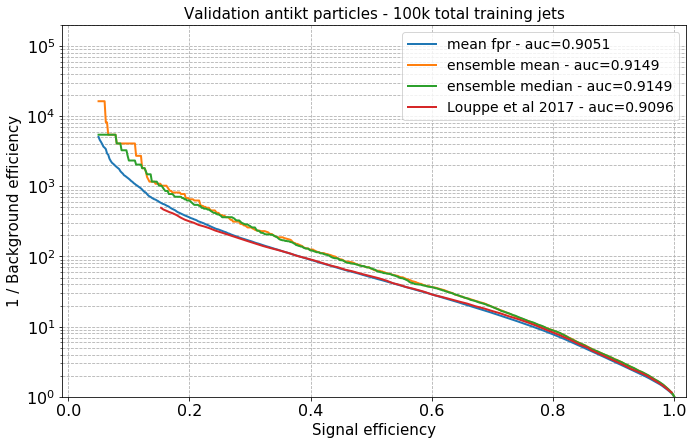

In [34]:
# Validation of Louppe et al 2017. Case Simple RecNN - antikt - particles. 
main_plot('./experiments/nyu_jet/nyu_jets_antikt-antikt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_100000_features_7',plot_name='Validation antikt particles', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,  validation=True, val_filename='../data/digitized_plots/fig4_antikt.csv', class_label='auc=0.9096')

# Loppe et al 2017 result is:
# &                      mean prob 	& 0.9096 $\pm$ 0.0013 	& 51.7 $\pm$ 3.5 \\ (This should match the mean fpr result reported below)

### Gated RecNN (antikt - particles)

Number of models plotted =  29
           	&                       mean fpr 	& acc: 0.8378    	& auc: 0.9112 $\pm$ 0.0090 	& R:62.9 $\pm$ 9.7 \\
           	&             ensemble mean prob 	& acc: 0.8442    	& auc: 0.9188 $\pm$ 0.0090 	& R:78.1 $\pm$ 9.7 \\
           	&           ensemble median prob 	& acc: 0.8439    	& auc: 0.9187 $\pm$ 0.0090 	& R:77.0 $\pm$ 9.7 \\


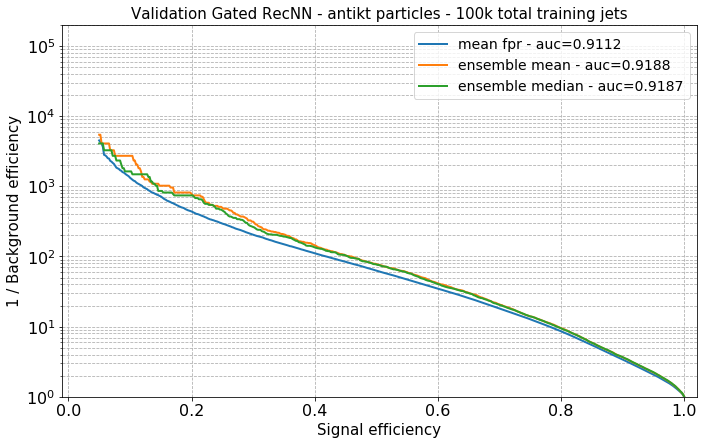

In [35]:
# Validation of Louppe et al 2017. Case Gated RecNN - antikt - particles
main_plot('./experiments/nyu_jet/nyu_jets_gatedRecNN_antikt-antikt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_100000_features_7',plot_name='Validation Gated RecNN - antikt particles', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False)
# Louppe et al 2017 result is:
#        	&                      mean prob 	& 0.9156 $\pm$ 0.0012 	& 68.3 $\pm$ 3.2 \\ (This should match the mean fpr result reported below)

## TOP TAG REFERENCE DATASET

### Check True labels

In [18]:
results_dic_test= load_results('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',show_data=False)
 
print('len(results_dic_test)=',len(results_dic_test))    
# yProbTrue=results_dic_test[0]['yProbTrue']     
yProbTrue= np.asarray([element['yProbTrue'] for element in results_dic_test])

print('shape y_Prob=',np.shape(yProbTrue))

# print('yProbTrue=',yProbTrue[0,300000:300020,1])
for i in range(len(yProbTrue)):
    unique, counts = np.unique(yProbTrue[i,:,1], return_counts=True)
    print('Number of sg and bg jets=',dict(zip(unique, counts)))
    
print('yTrue[0,20:40,1]=',yProbTrue[0,20:40,1])


len(results_dic_test)= 10
shape y_Prob= (10, 400000, 2)
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
Number of sg and bg jets= {0.0: 199974, 1.0: 200026}
yTrue[0,20:40,1]= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### NO PREPROCESSING

#### Simple RecNN

----------------------------------------
Number of models plotted =  8
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&                       mean fpr 	& acc: 0.9318    	& auc: 0.9818 $\pm$ 0.0001 	& R:983.4 $\pm$ 26.5 \\
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&             ensemble mean prob 	& acc: 0.9335    	& auc: 0.9825 $\pm$ 0.0001 	& R:1063.7 $\pm$ 26.5 \\
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&           ensemble median prob 	& acc: 0.9334    	& auc: 0.9824 $\pm$ 0.0001 	& R:1086.8 $\pm$ 26.5 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 7
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&                   median model 	& acc: 0.9319    	& auc: 0.9818 $\pm$ 0.0001 	& R:952.3 $\pm$ 26.0 \\
Position of model with median AUC in the sorted list= 4
----------------------------------------
Sorted by AUC - (auc, R)= [(0.9816816763154202, 994.8955223880598), (0.9

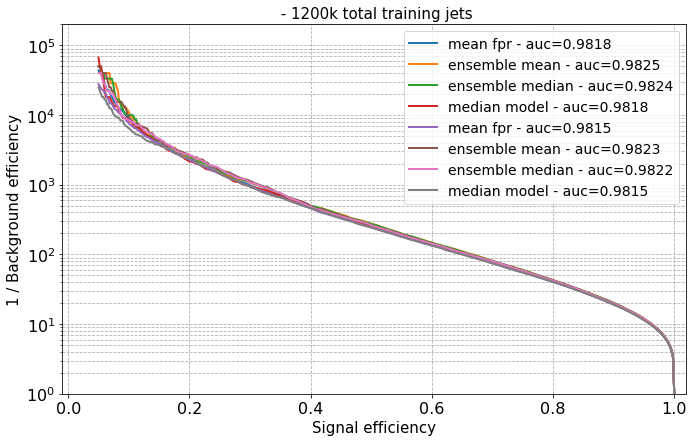

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [21]:
# Case Simple RecNN - kt algorithm
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25', show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25', show_plot=False)
print('----'*44)




# Case Simple RecNN - kt algorithm
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-3, batch=128, decay=0.9, epochs=40', show_plot=False)


#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='Simple RecNN - h_d=40, lr=5e-3, batch=128, decay=0.9, epochs=40', show_plot=True)
print('----'*44)


#Dipsikha'a result:
# AUC = 0.979, acc= 0.926,  bg rejection at 30% tag eff = 702

#### Gated

----------------------------------------
Number of models plotted =  9
           	&                       mean fpr 	& acc: 0.9308    	& auc: 0.9813 $\pm$ 0.0002 	& R:948.6 $\pm$ 46.2 \\
           	&             ensemble mean prob 	& acc: 0.9324    	& auc: 0.9821 $\pm$ 0.0002 	& R:1063.7 $\pm$ 46.2 \\
           	&           ensemble median prob 	& acc: 0.9324    	& auc: 0.9820 $\pm$ 0.0002 	& R:1052.5 $\pm$ 46.2 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 0
           	&                   median model 	& acc: 0.9311    	& auc: 0.9814 $\pm$ 0.0002 	& R:847.3 $\pm$ 46.2 \\
Position of model with median AUC in the sorted list= 4
Sorted by AUC - (auc, R)= [(0.9810310843169254, 921.5391705069125), (0.98117809471941, 938.8450704225352), (0.9811800881569435, 1015.0964467005076), (0.9813240416843763, 966.0579710144928), (0.9813634618225424, 847.3474576271187), (0.9813658174600823, 938.8450704225352), (0.9814015797481868, 980.2647058823528), (0.98144

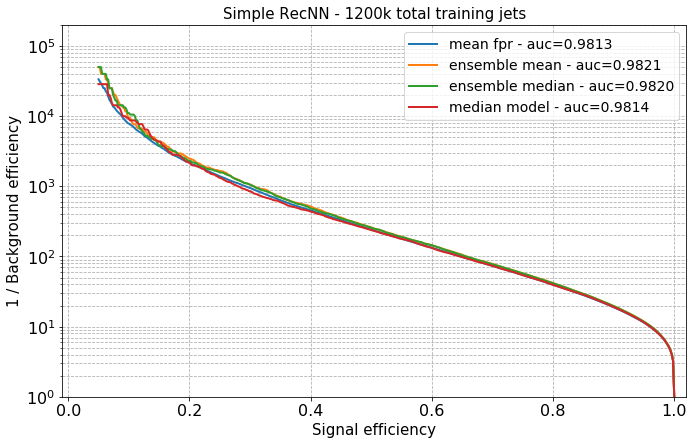

In [19]:
# Case Gated RecNN - kt algorithm
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_gatedRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3,show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_gatedRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True)



#### Leaves/inner different weights

----------------------------------------
Number of models plotted =  6
Leaves/inner RecNN 	&                       mean fpr 	& acc: 0.9315    	& auc: 0.9817 $\pm$ 0.0001 	& R:988.8 $\pm$ 36.3 \\
Leaves/inner RecNN 	&             ensemble mean prob 	& acc: 0.9327    	& auc: 0.9824 $\pm$ 0.0001 	& R:1047.0 $\pm$ 36.3 \\
Leaves/inner RecNN 	&           ensemble median prob 	& acc: 0.9327    	& auc: 0.9823 $\pm$ 0.0001 	& R:1069.4 $\pm$ 36.3 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 6
Leaves_inner_SimpleRecNN 	&                   median model 	& acc: 0.9316    	& auc: 0.9817 $\pm$ 0.0002 	& R:1052.5 $\pm$ 49.9 \\
Position of model with median AUC in the sorted list= 4
----------------------------------------
Sorted by AUC - (auc, R)= [(0.9811966395572232, 930.1116279069768), (0.9815904606263788, 966.0579710144928), (0.9816005128765487, 980.2647058823528), (0.9816328118020945, 865.6883116883117), (0.9816664943776638, 1052.4947368421053), (0.98169

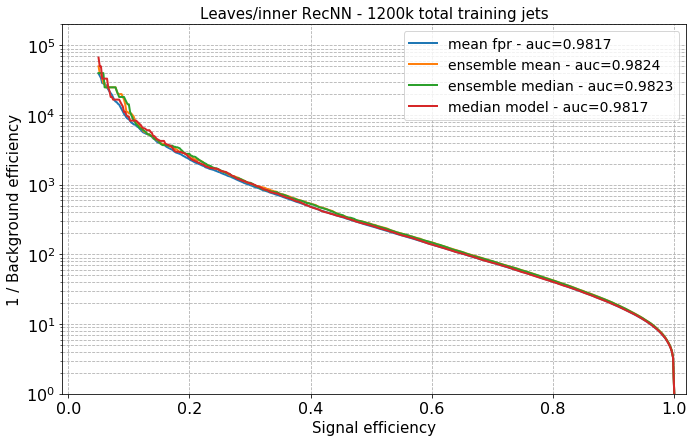

In [22]:
# Case leaves/inners different weights -  RecNN - kt algorithm
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_leaves_inner_RecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='Leaves/inner RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3,input_name='Leaves/inner RecNN', show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_leaves_inner_RecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='Leaves/inner RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='Leaves_inner_SimpleRecNN', show_plot=True,save_out_prob=True)


#### NiN - 2L4W - leaves/inner different weights for u_k and the NiN layers. NiN for h - BEST PERFORMING CASE !!!

Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:
- splitting between leaves and inner nodes in each NiN layer for j>1
- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).
 I use ReLU activations between NiN layers. The model has 62651 parameters.
----------------------------------------
Number of models plotted =  6
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128  	&                       mean fpr 	& acc: 0.9334    	& auc: 0.9825 $\pm$ 0.0001 	& R:1060.7 $\pm$ 54.5 \\
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9347    	& auc: 0.9831 $\pm$ 0.0001 	& R:1197.4 $\p

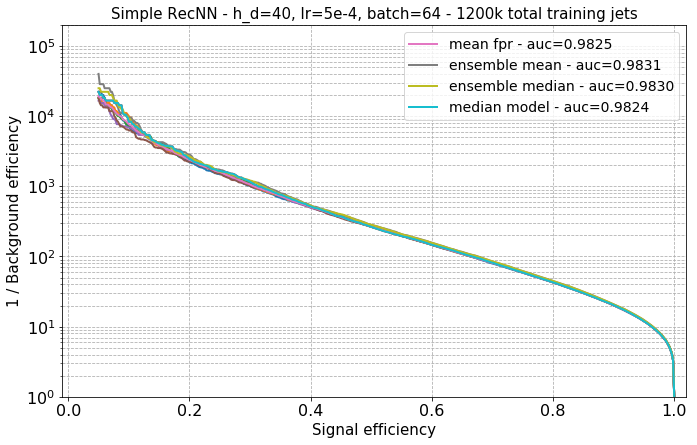

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [27]:
# RELU ACTIVATIONS BETWEEN NIN LAYERS - h_d=50
print('Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:\n- splitting between leaves and inner nodes in each NiN layer for j>1\n- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).\n I use ReLU activations between NiN layers. The model has 62651 parameters.')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128', show_plot=True, ensemble=False)
print('----'*44)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
# main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_80epochs_lr_2.95e-05_decay_0.86_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128', show_plot=True)
# print('----'*44)

Case NiN RecNN - kt algorithm  - h_d=40, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:
- splitting between leaves and inner nodes in each NiN layer for j>1
- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).
 I use ReLU activations between NiN layers. The model has  40521 parameters.
----------------------------------------
Number of models plotted =  10
2L4W leaves/inner ukNiN - h_d=40, lr=2e-3, batch=128  	&                       mean fpr 	& acc: 0.9331    	& auc: 0.9823 $\pm$ 0.0002 	& R:1033.6 $\pm$ 52.7 \\
2L4W leaves/inner ukNiN - h_d=40, lr=2e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9346    	& auc: 0.9830 $\pm$ 0.0002 	& R:1204.7 $

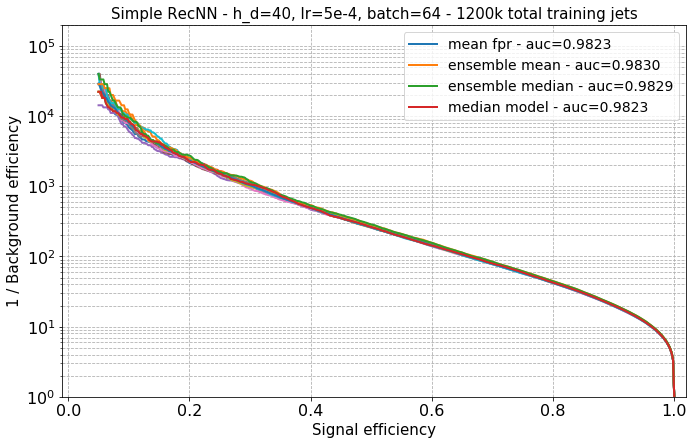

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [26]:
# RELU ACTIVATIONS BETWEEN NIN LAYERS - h_d=40
print('Case NiN RecNN - kt algorithm  - h_d=40, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:\n- splitting between leaves and inner nodes in each NiN layer for j>1\n- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).\n I use ReLU activations between NiN layers. The model has  40521 parameters.')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_40_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=40, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_40_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=40, lr=2e-3, batch=128', show_plot=True, ensemble=False)
print('----'*44)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
# main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_80epochs_lr_2.95e-05_decay_0.86_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128', show_plot=True)
# print('----'*44)

Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:
- splitting between leaves and inner nodes in each NiN layer for j>1
- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).
 I use TANH activations between NiN layers. The model has 62651 parameters.
----------------------------------------
Number of models plotted =  6
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128  	&                       mean fpr 	& acc: 0.9329    	& auc: 0.9822 $\pm$ 0.0004 	& R:1007.0 $\pm$ 36.1 \\
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9345    	& auc: 0.9829 $\pm$ 0.0004 	& R:1111.0 $\p

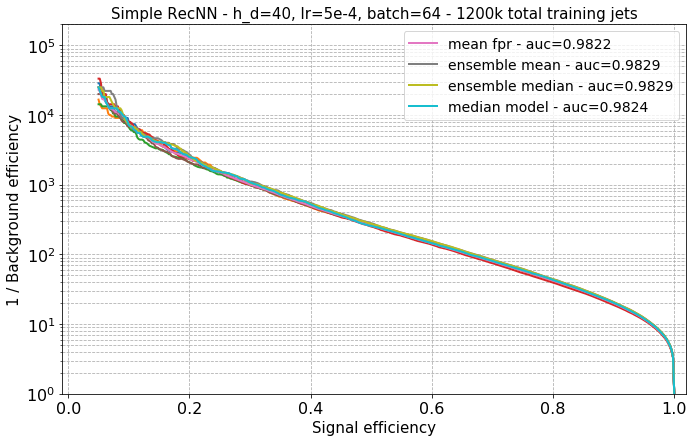

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [28]:
# TANH ACTIVATIONS BETWEEN NIN LAYERS
print('Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:\n- splitting between leaves and inner nodes in each NiN layer for j>1\n- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).\n I use TANH activations between NiN layers. The model has 62651 parameters.')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_tanh_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_tanh_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128', show_plot=True)
print('----'*44)

#### NiN - 2L6W - leaves/inner different weights for u_k and the NiN layers. NiN for u_k and h

Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 6 W each (j=1 left/right and j>1 inner and outer nodes and u_k). Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:
- splitting between leaves and inner nodes in each NiN layer for j>1
- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).
 I use ReLU activations between NiN layers. 
----------------------------------------
Number of models plotted =  2
2L6W leaves/inner NiN-u_k h - h_d=50, lr=2e-3, batch=128  	&                       mean fpr 	& acc: 0.9331    	& auc: 0.9823 $\pm$ 0.0001 	& R:1016.4 $\pm$ 36.1 \\
2L6W leaves/inner NiN-u_k h - h_d=50, lr=2e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9340    	& auc: 0.9827 $\pm$ 0.0001 	& R:1086.8 $\pm$ 36.1 \\
2L6W leaves/inner NiN-u_k h - h_d=50, lr=2e-3, b

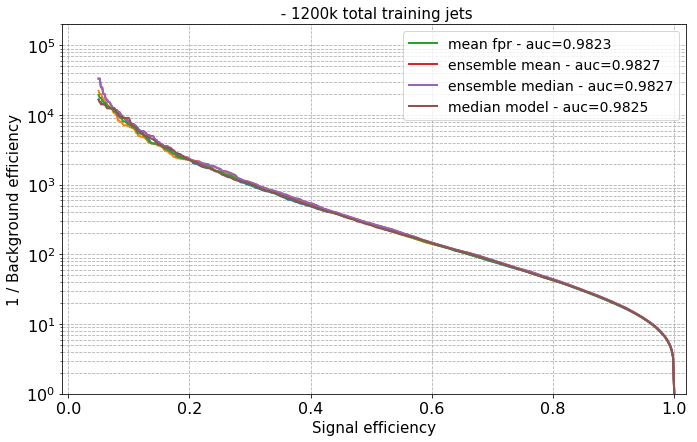

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [29]:
print('Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 6 W each (j=1 left/right and j>1 inner and outer nodes and u_k). Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:\n- splitting between leaves and inner nodes in each NiN layer for j>1\n- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).\n I use ReLU activations between NiN layers. ')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L6WleavesInnerNiN_ukh_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L6W leaves/inner NiN-u_k h - h_d=50, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L6WleavesInnerNiN_ukh_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L6W leaves/inner NiN-u_k h - h_d=50, lr=2e-3, batch=128', show_plot=True)
print('----'*44)

#### NiN - 2L3W - leaves/inner different weights for u_k and the NiN layers

Case NiN 2L3W RecNN - kt algorithm  - h_d=50, lr=2e-3, decay=0.86, epochs=45, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). ReLU everything
----------------------------------------
Number of models plotted =  5
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128   	&                       mean fpr 	& acc: 0.9332    	& auc: 0.9823 $\pm$ 0.0000 	& R:1069.0 $\pm$ 45.1 \\
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128   	&             ensemble mean prob 	& acc: 0.9341    	& auc: 0.9829 $\pm$ 0.0000 	& R:1197.4 $\pm$ 45.1 \\
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128   	&           ensemble median prob 	& acc: 0.9339    	& auc: 0.9828 $\pm$ 0.0000 	& R:1176.3 $\pm$ 45.1 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 7
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128 	&                   median model 	& acc: 0.9331    	& auc: 0.9823 $\pm$ 0.0001 	& R:1047.0 $\pm$ 35.8 \\
Position of model with median AUC in the sor

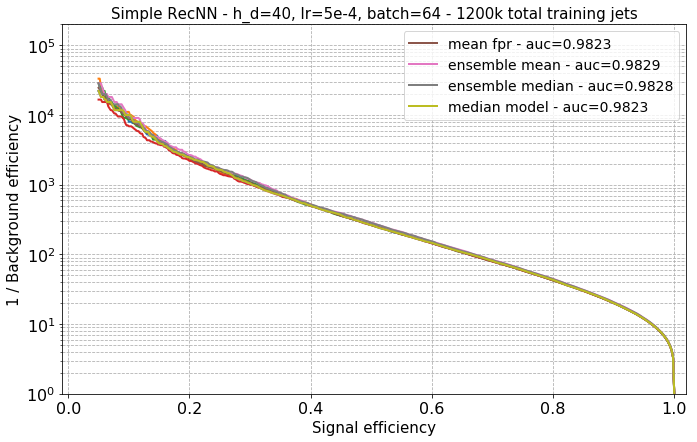

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [30]:
print('Case NiN 2L3W RecNN - kt algorithm  - h_d=50, lr=2e-3, decay=0.86, epochs=45, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). ReLU everything')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN2L3W_kt_2L3WleavesInnerNiNuk_loss_lr_0.002_decay_0.86_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128  ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN2L3W_kt_2L3WleavesInnerNiNuk_loss_lr_0.002_decay_0.86_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128', show_plot=True)
print('----'*44)

In [32]:
# print('Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). ReLU everything')
# main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN2L3W_kt_2L3WleavesInnerNiNuk_lr_0.002_decay_0.86_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128  ',show_plot=False)

# #Top tag reference method: plot only the run that gives the median auc out ot 9 runs
# main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN2L3W_kt_2L3WleavesInnerNiNuk_lr_0.002_decay_0.86_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128', show_plot=True)
# print('----'*44)

#### Gated + NiN

Case Gated NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 and j>1 inner and outer nodes). ReLU everything. Split leaves/inner nodes from features to u_k and NiN layer
----------------------------------------
Number of models plotted =  7
2L4W leaves/inner NiN - h_d=50, lr=2e-3, batch=128, epochs=50   	&                       mean fpr 	& acc: 0.9336    	& auc: 0.9826 $\pm$ 0.0002 	& R:1063.9 $\pm$ 16.0 \\
2L4W leaves/inner NiN - h_d=50, lr=2e-3, batch=128, epochs=50   	&             ensemble mean prob 	& acc: 0.9351    	& auc: 0.9832 $\pm$ 0.0002 	& R:1123.4 $\pm$ 16.0 \\
2L4W leaves/inner NiN - h_d=50, lr=2e-3, batch=128, epochs=50   	&           ensemble median prob 	& acc: 0.9350    	& auc: 0.9832 $\pm$ 0.0002 	& R:1155.9 $\pm$ 16.0 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 8
2L4W leaves/inner NiN - h_d=50, lr=2e-3, batch=128, epochs=50 	&                   median model 	& acc: 0.9340    	& auc: 0.9826 

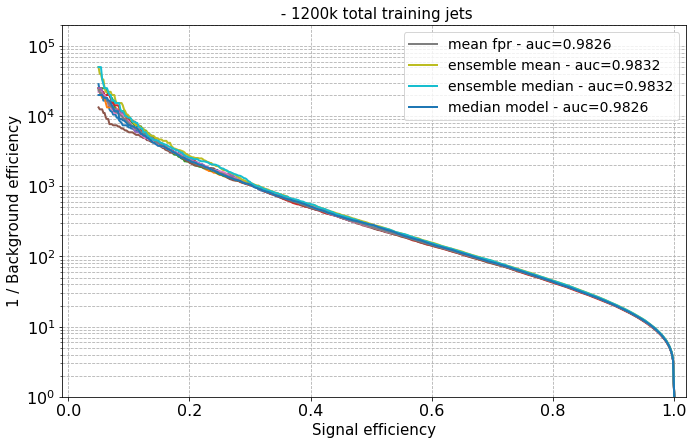

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [33]:
print('Case Gated NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 and j>1 inner and outer nodes). ReLU everything. Split leaves/inner nodes from features to u_k and NiN layer')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNgatedRecNN_kt_2L4WleavesInnerNiNuk_bgRejectionbest_lr_0.002_decay_0.9_batch_128_epochs_50_hidden_50_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner NiN - h_d=50, lr=2e-3, batch=128, epochs=50  ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNgatedRecNN_kt_2L4WleavesInnerNiNuk_bgRejectionbest_lr_0.002_decay_0.9_batch_128_epochs_50_hidden_50_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner NiN - h_d=50, lr=2e-3, batch=128, epochs=50', show_plot=True)
print('----'*44)

Case Gated NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 6 W each (j=1 and j>1 inner and outer nodes). ReLU everything
----------------------------------------
Number of models plotted =  1
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128   	&                       mean fpr 	& acc: 0.9336    	& auc: 0.9827 $\pm$ 0.0000 	& R:1036.1 $\pm$ 0.0 \\
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128   	&             ensemble mean prob 	& acc: 0.9336    	& auc: 0.9827 $\pm$ 0.0000 	& R:1036.1 $\pm$ 0.0 \\
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128   	&           ensemble median prob 	& acc: 0.9336    	& auc: 0.9827 $\pm$ 0.0000 	& R:1036.1 $\pm$ 0.0 \\
----------------------------------------
Number of models plotted =  1
top_ref_run= 0
2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128 	&                   median model 	& acc: 0.9336    	& auc: 0.9827 $\pm$ 0.0000 	& R:1036.1 $\pm$ 0.0 \\
Position of model with median AUC in the sorted list= 0
--------------

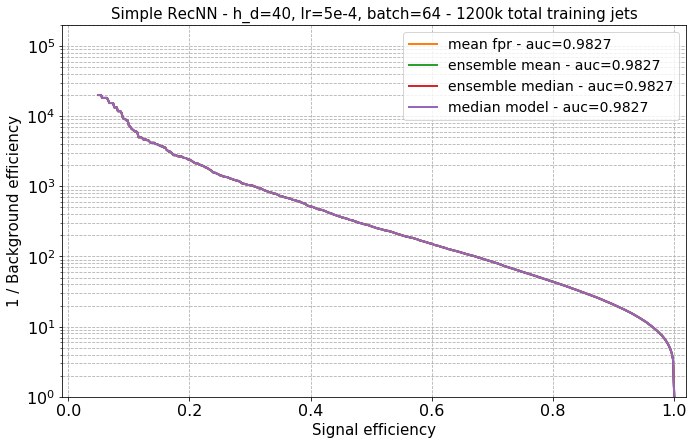

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [35]:
print('Case Gated NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 6 W each (j=1 and j>1 inner and outer nodes). ReLU everything')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNgatedRecNN_kt_2L6WleavesInnerNiN_ukh_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128  ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNgatedRecNN_kt_2L6WleavesInnerNiN_ukh_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L3W leaves/inner NiN - h_d=50, lr=2e-3, batch=128', show_plot=True)
print('----'*44)

### PREPROCESSED DATA

Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:
- splitting between leaves and inner nodes in each NiN layer for j>1
- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).
 I use ReLU activations between NiN layers. The model has 75251 parameters.
NO PREPROCESSING
----------------------------------------
Number of models plotted =  6
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128  	&                       mean fpr 	& acc: 0.9334    	& auc: 0.9825 $\pm$ 0.0001 	& R:1060.7 $\pm$ 54.5 \\
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9347    	& auc: 0.9831 $\pm$ 0.000

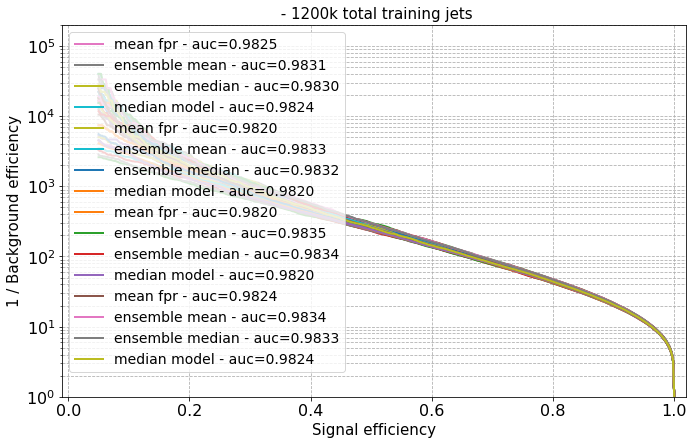

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [20]:
# RELU ACTIVATIONS BETWEEN NIN LAYERS - h_d=50
print('Case NiN RecNN - kt algorithm  - h_d=50, lr=2e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)  Also leaves/inners different weights (u_k) .Split weights for inner nodes and leaves to go from the initial features to the embeddings. I also apply 2 fully connected NiN layers:\n- splitting between leaves and inner nodes in each NiN layer for j>1\n- splitting between left and right nodes on the first layer (j=1). (These weights are different from the ones for j>1).\n I use ReLU activations between NiN layers. The model has 75251 parameters.')

print('NO PREPROCESSING')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128', show_plot=False, ensemble=False)
print('----'*44)
print('----'*44)
print('PREPROCESSED DATA')
print('----'*44)
print('h_d=50, lr=2e-3, decay=0.9, batch=128')
print('----'*22)
print('Evaluated on models that give the best bg rejection at 30% tag eff on the val set')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_R_0.3_rot_boost_rot_flip_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_R_0.3_rot_boost_rot_flip_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128', show_plot=False, ensemble=False)

print('----'*22)
print('----'*22)
print('Evaluated on the models obtained after the last epoch')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_R_0.3_rot_boost_rot_flip_last_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=True,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_R_0.3_rot_boost_rot_flip_last_lr_0.002_decay_0.9_batch_128_epochs_45_hidden_50_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128', show_plot=False, ensemble=False)

print('----'*44)
print('----'*44)
print('h_d=40, lr=5e-4, decay=0.92, batch=64')
print('----'*22)
print('Evaluated on models that give the best bg rejection at 30% tag eff on the val set')

main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_R_0.3_rot_boost_rot_flip_lr_0.0005_decay_0.92_batch_64_epochs_40_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=40, lr=5e-4, decay=0.92, batch=64', show_plot=False)


#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNNReLU_kt_R_0.3_rot_boost_rot_flip_lr_0.0005_decay_0.92_batch_64_epochs_40_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=40, lr=5e-4, decay=0.92, batch=64', show_plot=True)
print('----'*44)

NO PREPROCESSING
----------------------------------------
Number of models plotted =  8
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&                       mean fpr 	& acc: 0.9318    	& auc: 0.9818 $\pm$ 0.0001 	& R:983.4 $\pm$ 26.5 \\
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&             ensemble mean prob 	& acc: 0.9335    	& auc: 0.9825 $\pm$ 0.0001 	& R:1063.7 $\pm$ 26.5 \\
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&           ensemble median prob 	& acc: 0.9334    	& auc: 0.9824 $\pm$ 0.0001 	& R:1086.8 $\pm$ 26.5 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 7
Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25 	&                   median model 	& acc: 0.9319    	& auc: 0.9818 $\pm$ 0.0001 	& R:952.3 $\pm$ 26.0 \\
Position of model with median AUC in the sorted list= 4
----------------------------------------
Sorted by AUC - (auc, R)= [(0.9816816763154202, 994.895

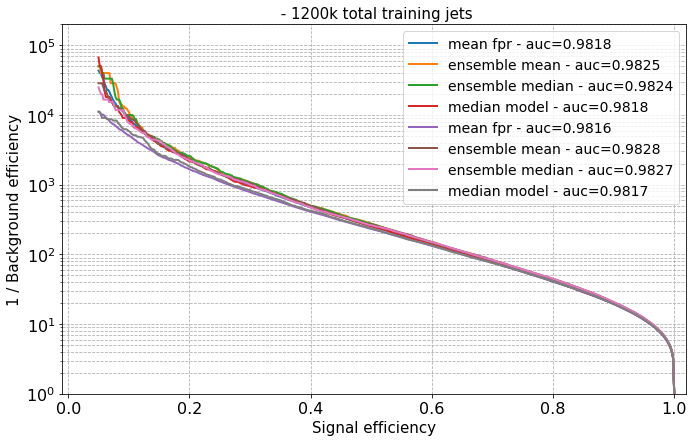

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [14]:
print('NO PREPROCESSING')
# Case Simple RecNN - kt algorithm
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25', show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='Simple RecNN - h_d=40, lr=5e-4, batch=64, decay=0.9, epochs=25', show_plot=False)
print('----'*44)
print('----'*44)
print('PREPROCESSED DATA')
print('----'*22)
print('Evaluated on models that give the best bg rejection at 30% tag eff on the val set')
# Case Simple RecNN - kt algorithm
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_R_0.3_rot_boost_rot_flip_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-3, batch=128, decay=0.9, epochs=40', show_plot=False)


#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_R_0.3_rot_boost_rot_flip_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_1200000_features_7',plot_name='', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='Simple RecNN - h_d=40, lr=5e-3, batch=128, decay=0.9, epochs=40', show_plot=True)
print('----'*44)


### GET STATISTICS OVER ALL POSSIBLE ENSEMBLES OF 3 MODELS EACH

----------------------------------------
Number of models plotted =  9
top_ref_run= 6
2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128 	&                   median model 	& acc: 0.9331    	& auc: 0.9824 $\pm$ 0.0001 	& R:1162.6 $\pm$ 49.0 \\
Position of model with median AUC in the sorted list= 4
Sorted by AUC - (auc, R)= [(0.9823660174769857, 994.8955223880598), (0.9823735427646129, 1052.4947368421053), (0.9823774588771791, 1041.53125), (0.9823866669273347, 1020.2755102040817), (0.9823886315898678, 1162.639534883721), (0.9824049298026432, 1030.7938144329896), (0.9824729999412938, 1015.0964467005076), (0.9825104651544269, 1104.828729281768), (0.9825437388799892, 1030.7938144329896)]
----------------------------------------
All bg rejection factors at  0.3 tag eff = [1020.2755102  1030.79381443  994.89552239 1041.53125    1052.49473684
 1104.82872928 1162.63953488 1030.79381443 1015.0964467 ]
Mean and std of all the bg rections =  1050.372151018469 +- 49.042626869144435
Median and st

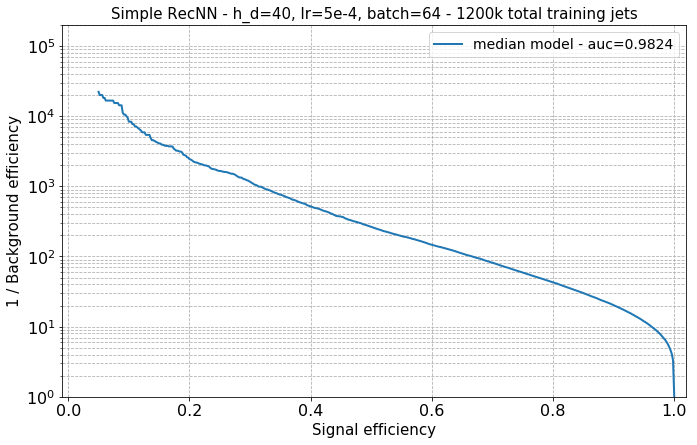

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [17]:
#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.002_decay_0.9_batch_128_epochs_40_hidden_50_Njets_1200000_features_7',plot_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=2e-3, batch=128', show_plot=True, ensemble=True)
print('----'*44)

## Tests with 120k training - 40k val - 40k test jets - NO PREPROCESSING

Case Simple RecNN - kt algorithm  - h_d=40, lr=5e-4, batch=64
----------------------------------------
Number of models plotted =  5
Simple RecNN - h_d=40, lr=5e-4, batch=64 	&                       mean fpr 	& acc: 0.9099    	& auc: 0.9687 $\pm$ 0.0013 	& R:223.8 $\pm$ 10.1 \\
Simple RecNN - h_d=40, lr=5e-4, batch=64 	&             ensemble mean prob 	& acc: 0.9151    	& auc: 0.9720 $\pm$ 0.0013 	& R:264.5 $\pm$ 10.1 \\
Simple RecNN - h_d=40, lr=5e-4, batch=64 	&           ensemble median prob 	& acc: 0.9142    	& auc: 0.9718 $\pm$ 0.0013 	& R:231.0 $\pm$ 10.1 \\
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Case Simple RecNN - kt algorithm  - h_d=50, lr=5e-4, batch=128
----------------------------------------
Number of models plotted =  7
Simple RecNN - h_d=50, lr=5e-4, batch=128  	&                       mean fpr 	& acc: 0.9079    	& auc: 0.9671 $\pm$ 0.

----------------------------------------
Number of models plotted =  8
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&                       mean fpr 	& acc: 0.9238    	& auc: 0.9774 $\pm$ 0.0007 	& R:595.1 $\pm$ 154.9 \\
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9282    	& auc: 0.9797 $\pm$ 0.0007 	& R:1003.0 $\pm$ 154.9 \\
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&           ensemble median prob 	& acc: 0.9279    	& auc: 0.9795 $\pm$ 0.0007 	& R:835.8 $\pm$ 154.9 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 1
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128 	&                   median model 	& acc: 0.9230    	& auc: 0.9773 $\pm$ 0.1985 	& R:409.4 $\pm$ nan \\
Position of model with median AUC in the sorted list= 4
----------------------------------------
Sorted by AUC - (auc, R)= [(0.5, nan), (0.5, nan), (0.9760579889933743, 527.8947368421052), (0.9772960952120

/opt/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


----------------------------------------
Number of models plotted =  12
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&                       mean fpr 	& acc: 0.9242    	& auc: 0.9775 $\pm$ 0.0003 	& R:590.7 $\pm$ 54.3 \\
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9290    	& auc: 0.9798 $\pm$ 0.0003 	& R:872.2 $\pm$ 54.3 \\
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&           ensemble median prob 	& acc: 0.9285    	& auc: 0.9796 $\pm$ 0.0003 	& R:716.4 $\pm$ 54.3 \\
----------------------------------------
Number of models plotted =  9
top_ref_run= 4
2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128  	&                   median model 	& acc: 0.9235    	& auc: 0.9774 $\pm$ 0.0004 	& R:590.0 $\pm$ 57.4 \\
Position of model with median AUC in the sorted list= 4
----------------------------------------
Sorted by AUC - (auc, R)= [(0.9767248315428037, 647.0967741935484), (0.9772373448681928, 501.50000000000006),

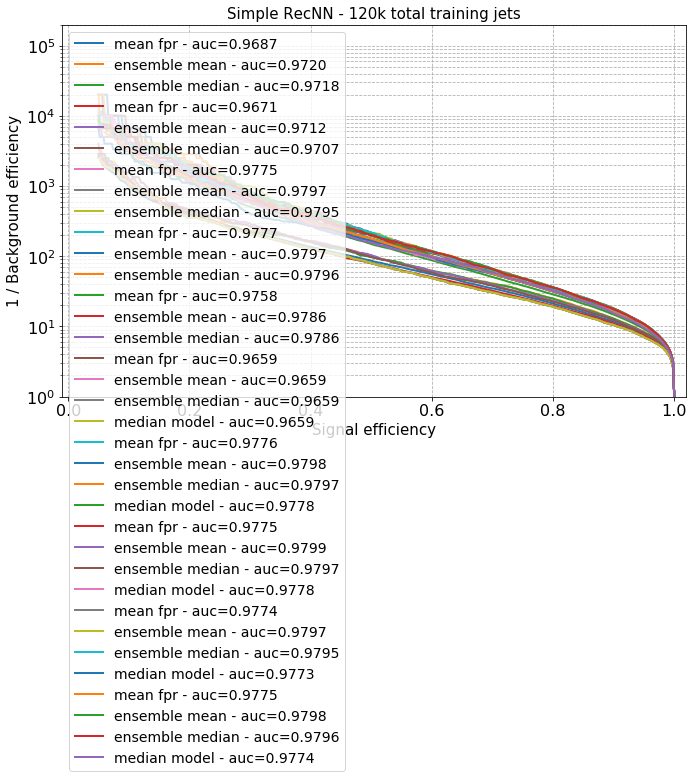

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [38]:
print('Case Simple RecNN - kt algorithm  - h_d=40, lr=5e-4, batch=64')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-4, batch=64', show_plot=False)
print('----'*44)

print('Case Simple RecNN - kt algorithm  - h_d=50, lr=5e-4, batch=128')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.0005_decay_0.9_batch_128_epochs_30_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=50, lr=5e-4, batch=128 ', show_plot=False)
print('----'*44)

print('Case Simple RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_35_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=50, lr=5e-3, batch=128 ', show_plot=False)
print('----'*44)

print('Case Simple RecNN - kt algorithm  - h_d=40, lr=5e-3, batch=128')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-3, batch=128 ', show_plot=False)
print('----'*44)

print('Case gated RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_gatedRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Gated - h_d=50, lr=5e-3, batch=128 ', show_plot=False)
print('----'*44)


print('Case leaves/inners different weights -  RecNN - kt algorithm')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_leaves_inner_RecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_120000_features_7',plot_name='Leaves/inner RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3,input_name='Leaves/inner RecNN', show_plot=False)

# #Case leaves/inners different weights - Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_leaves_inner_RecNN_kt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, show_plot=False)
print('----'*44)

print('Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). ReLU everything')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L3WleavesInnerNiN_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128 ', show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L3WleavesInnerNiN_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128 ',show_plot=False)

print('----'*44)


print('Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). tanh between NiN layers, ReLU everything else')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L3WleavesInnerNiN_tanh_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128 ', show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L3WleavesInnerNiN_tanh_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128 ',show_plot=False)
print('----'*44)



print('Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k) - NEW')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L4WleavesInnerNiNuk_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128',show_plot=False)
print('----'*44)

print('Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 4 W each (j=1 left/right and j>1 inner and outer nodes). Also leaves/inners different weights (u_k)')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_2L4WleavesInner_ukNiN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='NiN RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_2L4WleavesInner_ukNiN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3, input_name='2L4W leaves/inner ukNiN - h_d=50, lr=5e-3, batch=128 ',top_ref=True)
print('----'*44)



#Dipsikha'a result:
# AUC = 0.979, acc= 0.926,  bg rejection at 30% tag eff = 702

----------------------------------------
Number of models plotted =  9
Simple RecNN - h_d=50, lr=5e-3, batch=128 	&                       mean fpr 	& acc: 0.9239    	& auc: 0.9775 $\pm$ 0.0008 	& R:627.9 $\pm$ 96.9 \\
Simple RecNN - h_d=50, lr=5e-3, batch=128 	&             ensemble mean prob 	& acc: 0.9285    	& auc: 0.9797 $\pm$ 0.0008 	& R:835.8 $\pm$ 96.9 \\
Simple RecNN - h_d=50, lr=5e-3, batch=128 	&           ensemble median prob 	& acc: 0.9281    	& auc: 0.9795 $\pm$ 0.0008 	& R:835.8 $\pm$ 96.9 \\
----------------------------------------
Number of models plotted =  9
           	&                   median model 	& acc: 0.9234    	& auc: 0.9776 $\pm$ 0.0008 	& R:501.5 $\pm$ 96.9 \\
----------------------------------------
All bg rejection factors at  0.3 tag eff = [573.14285714 626.875      607.87878788 802.4        542.16216216
 501.5        771.53846154 668.66666667 557.22222222]
-------------------------------------------------------------------------------------------------

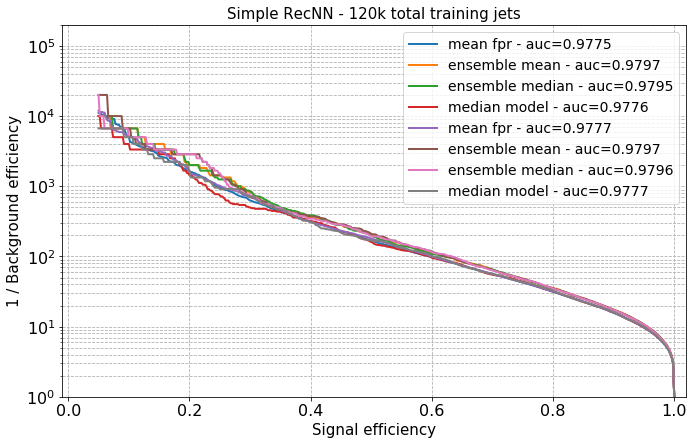

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [68]:


main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_35_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=50, lr=5e-3, batch=128' , show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_35_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True,show_plot=False)
print('----'*44)



main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='Simple RecNN - h_d=40, lr=5e-3, batch=128 ',show_plot=False)

#Top tag reference method: plot only the run that gives the median auc out ot 9 runs
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_simpleRecNN_kt_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_40_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=False,mean_prob=False,median_prob=False,show_all=False,tag_eff=0.3,top_ref=True)
print('----'*44)

Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). ReLU everything
Number of models plotted =  10
2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128  	&                       mean fpr 	& acc: 0.9243    	& auc: 0.9776 $\pm$ 0.0003 	& R:597.5 $\pm$ 104.8 \\
2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128  	&             ensemble mean prob 	& acc: 0.9290    	& auc: 0.9798 $\pm$ 0.0003 	& R:802.4 $\pm$ 104.8 \\
2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128  	&           ensemble median prob 	& acc: 0.9290    	& auc: 0.9797 $\pm$ 0.0003 	& R:771.5 $\pm$ 104.8 \\
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). tanh between NiN layers, ReLU everything else
Number of mode

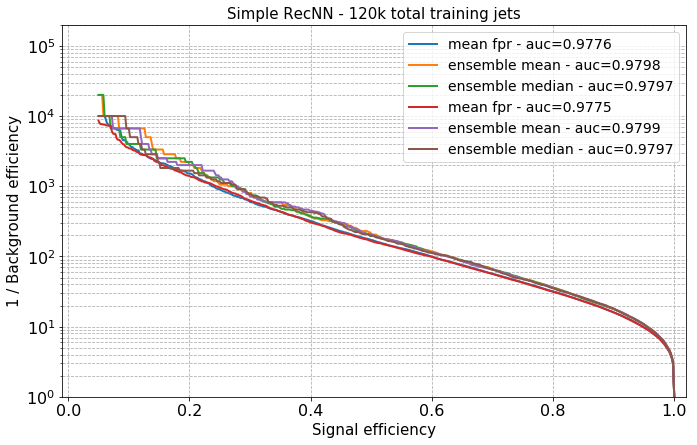

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [52]:
print('Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). ReLU everything')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L3WleavesInnerNiN_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128 ', show_plot=False)
print('----'*44)


print('Case NiN RecNN - kt algorithm  - h_d=50, lr=5e-3, batch=128. 2 NiN layers, 3 W each (j=1 and j>1 inner and outer nodes). tanh between NiN layers, ReLU everything else')
main_plot('./experiments/top_tag_reference_dataset/top_tag_reference_dataset_NiNRecNN_kt_2L3WleavesInnerNiN_tanh_lr_0.005_decay_0.9_batch_128_epochs_40_hidden_50_Njets_120000_features_7',plot_name='Simple RecNN', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,tag_eff=0.3, input_name='2L3W leaves/inner NiN - h_d=50, lr=5e-3, batch=128 ')

print('----'*44)

In [41]:
# Test plotting multiple plots together
# main_plot('./experiments/nyu_jet/nyu_jets_antikt-antikt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_100000_features_7',plot_name='Validation antikt particles', factor=0.001, report=True, mean_fpr=True,mean_prob=True,median_prob=True,show_all=False,  validation=True, val_filename='../data/digitized_plots/fig4_antikt.csv', class_label='auc=0.9096', show_plot=False)

# main_plot('./experiments/nyu_jet/nyu_jets_gatedRecNN_antikt-antikt_lr_0.0005_decay_0.9_batch_64_epochs_25_hidden_40_Njets_100000_features_7',plot_name='Validation Gated RecNN - antikt particles', factor=0.001, report=True, mean_fpr=True,mean_prob=False,median_prob=False,show_all=True,  show_plot=False)

# plot_show(filename='test',totjets='100000',title='joint plot')